# Model Predictive Control for DED using GAMMA, Pytorch Implementation
created on 5/22/2024

In [ ]:
# Import all the packages we need
import numpy as np
import pandas as pd
from typing import Optional, Tuple
import sys

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time
from tqdm import tqdm

# from pytorch_forecasting.metrics.quantile import QuantileLoss

# from scipy.optimize import minimize, Bounds

# For TiDE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(1)
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

from sklearn.preprocessing import StandardScaler
from torch.nn import functional as F

import os
import shutil
import warnings
import pickle

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

# import functions
from TiDE import TideModule, quantile_loss, TiDE_forward

from nn_functions import surrogate
from torchmin import minimize as pytorch_minimize
from scipy.optimize import minimize, Bounds

from moving_average import moving_average_1d
import copy

from GAMMA_obj_temp_depth import GAMMA_obj
from obj_fun_depth import RMPC_obj_wo_constraint
from GAMMA_MPC_temp_depth import GAMMA_MPC



cuda is available


### Load pre-trained model

In [2]:
with open('TiDE_params_single_track_square_MV_temp_depth_less_cov_w50_p50.pkl', 'rb') as file:

   
    # 2. Load the data from the pickle file
    nominal_params = pickle.load(file)
# Load nominal TiDE model
nominal_TiDE = nominal_params['model'].to("cpu")
P = 50
window = 50

In [3]:
total_params = sum(p.numel() for p in nominal_TiDE.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 796594


### Build class for ML surrogate

In [4]:
'''
inputs:
    nominal_param: nominal parameters saved from nominal_preparation
    nominal_TiDE   : a complete nn.module model with the pretrained parameters are loaded
'''
TiDE = surrogate(nominal_params, nominal_TiDE)

### Load reference trajectory

#### Run GAMMA for initialization

In [5]:
INPUT_DATA_DIR = "data"
SIM_DIR_NAME = "single_track_square"
BASE_LASER_FILE_DIR = "laser_power_profiles/csv"
CLOUD_TARGET_BASE_PATH = "result"
solidus_temp = 1600
window = 50
sim_interval = 5
init_runs = 50 # number of initial runs before MPC starts

GAMMA_class = GAMMA_obj(INPUT_DATA_DIR, SIM_DIR_NAME, BASE_LASER_FILE_DIR, CLOUD_TARGET_BASE_PATH, solidus_temp, window, init_runs, sim_interval)
init_avg = GAMMA_class.run_initial_steps()
init_avg = torch.tensor(init_avg,dtype=torch.float32)[:,-window:] # shape = [2,50]

100%|██████████| 250/250 [00:14<00:00, 17.54it/s]


#### Fix covariates as the configuration is given

In [6]:
df_one_print = pd.read_csv('single_track_ref.csv')

loc_X_list = df_one_print["X"].to_numpy().reshape(-1,1)
loc_Y_list = df_one_print["Y"].to_numpy().reshape(-1,1)
loc_Z_list = df_one_print["Z"].to_numpy().reshape(-1,1)
dist_X_list = df_one_print["Dist_to_nearest_X"].to_numpy().reshape(-1,1)
dist_Y_list = df_one_print["Dist_to_nearest_Y"].to_numpy().reshape(-1,1)
scan_spd_list = df_one_print["scanning_speed"].to_numpy().reshape(-1,1)
# laser on/off indicator
laser_on_off = df_one_print["laser_power_number"].to_numpy().reshape(-1,1)
# laser power
laser_power_ref = torch.tensor(df_one_print["Laser_power"].to_numpy().reshape(-1,1),dtype=torch.float32)
laser_power_past = laser_power_ref[:window]

fix_covariates = torch.tensor(np.concatenate((loc_Z_list,dist_X_list,dist_Y_list),axis=1),dtype=torch.float32)

# temporary ref
# apply moving average for mp temp
mp_temp_raw = df_one_print["melt_pool_temperature"].to_numpy()
mp_temp_mv = moving_average_1d(mp_temp_raw,4)
mp_temp = copy.deepcopy(mp_temp_raw)
mp_temp[1:-2] = mp_temp_mv
mp_temp = mp_temp

mp_temp_ref = torch.tensor(mp_temp,dtype=torch.float32)



In [7]:
MPC_GAMMA = GAMMA_MPC(GAMMA_class, TiDE, RMPC_obj_wo_constraint, mp_temp_ref, window, P, fix_covariates, init_avg, laser_power_past)

N_step = 6196 - init_runs + 50

RUN = "MPC"

if RUN == "MPC":
    for i in tqdm(range(N_step)):
        MPC_GAMMA.MPC_run_one_step_pytorch()

elif RUN == "PID":
    for i in tqdm(range(N_step)):
        MPC_GAMMA.PID_run_one_step()
        
else:
    print(f"No control method available")

  0%|          | 11/6196 [00:06<1:03:05,  1.63it/s]


KeyboardInterrupt: 

In [ ]:
MPC_GAMMA.TiDE.x_max[0][3]

tensor(732.2975)

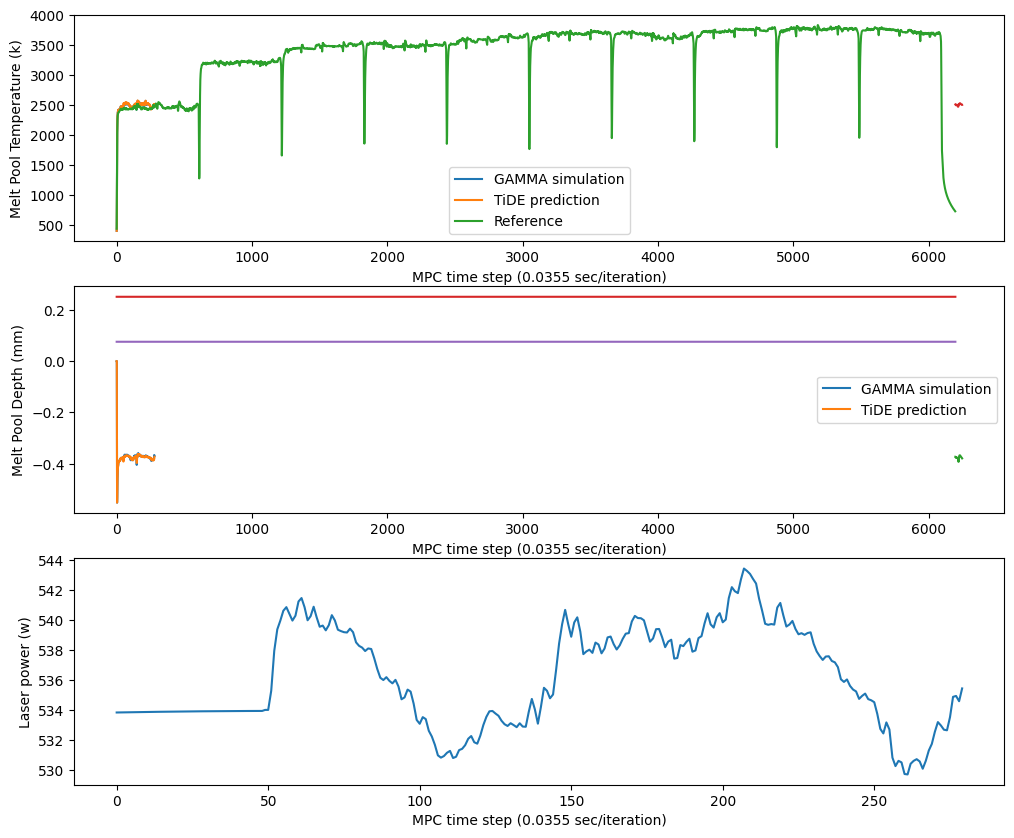

In [ ]:
N_step = 6196
plt.figure(figsize=[12,10])
plt.subplot(3,1,1)
plt.plot(MPC_GAMMA.x_past_save[:N_step,0], label = "GAMMA simulation")
plt.plot(MPC_GAMMA.NN_pred_save.detach().numpy()[:N_step,0], label="TiDE prediction")
plt.plot(MPC_GAMMA.ref[:N_step], label="Reference")
plt.plot(np.linspace(N_step,N_step+50,50),MPC_GAMMA.instant_pred[:,0].detach().numpy())
plt.legend()


plt.xlabel("MPC time step (0.0355 sec/iteration)")
plt.ylabel("Melt Pool Temperature (k)")

plt.subplot(3,1,2)
plt.plot(MPC_GAMMA.x_past_save[:N_step,1], label = "GAMMA simulation")
plt.plot(MPC_GAMMA.NN_pred_save.detach().numpy()[:N_step,1], label="TiDE prediction")
plt.plot(np.linspace(N_step,N_step+50,50),MPC_GAMMA.instant_pred[:,1].detach().numpy())
plt.plot(np.linspace(0,N_step,N_step),0.25*np.ones(N_step))
plt.plot(np.linspace(0,N_step,N_step),0.075*np.ones(N_step))
plt.xlabel("MPC time step (0.0355 sec/iteration)")
plt.ylabel("Melt Pool Depth (mm)")
plt.legend()

plt.subplot(3,1,3)
plt.plot(MPC_GAMMA.u_past_save[:N_step])
plt.ylabel("Laser power (w)")
plt.xlabel("MPC time step (0.0355 sec/iteration)")
plt.show()


0.31104015785714856

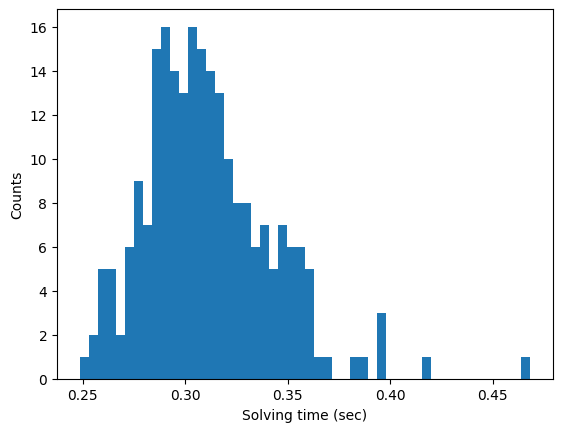

In [ ]:
time = np.array(MPC_GAMMA.save_time) * -1
plt.hist(time,50)
plt.xlabel("Solving time (sec)")
plt.ylabel("Counts")
np.mean(time)

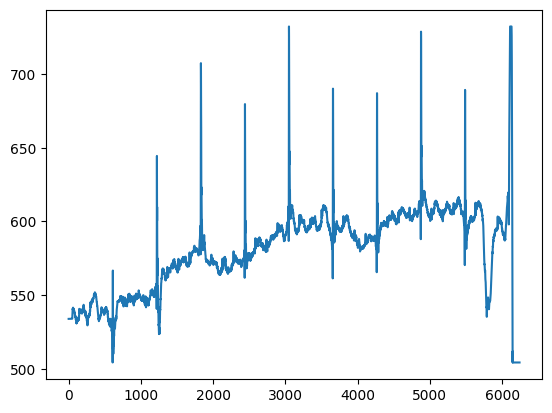

In [ ]:
plt.plot(MPC_GAMMA.u_past_save)

In [ ]:
gamma_result = MPC_GAMMA.x_past_save[:N_step]
ref = MPC_GAMMA.ref[:N_step]
TiDE_pred = MPC_GAMMA.NN_pred_save.detach().numpy()[:N_step]
LP = MPC_GAMMA.u_past_save[:N_step]


ref.shape

torch.Size([6196])

In [ ]:
import pandas as pd
# Assuming the three variables are numpy arrays or lists
gamma_result = MPC_GAMMA.x_past_save[:N_step].squeeze()
ref = MPC_GAMMA.ref[:N_step]
TiDE_pred = MPC_GAMMA.NN_pred_save.detach().numpy()[:N_step].squeeze()
LP = MPC_GAMMA.u_past_save[:N_step].squeeze()

# Create a dictionary with the data
data = {
    'gamma_result': gamma_result,
    'ref': ref,
    'TiDE_pred': TiDE_pred,
    'LP': LP
}

data = {
    'gamma_result': gamma_result,
    'ref': ref,
    'LP': LP
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('profile_1_PID.csv', index=False)


ValueError: Data must be 1-dimensional, got ndarray of shape (6196, 2) instead